In [1]:
!pip install jcopdl

  Preparing metadata (setup.py) ... done
  Created wheel for jcopdl: filename=jcopdl-1.1.9-py2.py3-none-any.whl size=16924 sha256=4a106c63c1030241ee3d20b06c108f0ffc6ffd290ae1e5ee647f74a1c65d1c4f
  Stored in directory: /root/.cache/pip/wheels/e5/78/9d/931694cba38491e16f1a94719193211fd12a7307570d9bb562
Successfully built jcopdl


**IMPORT PACKAGES**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

**DATASET & DATALOADER**

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [4]:
bs = 32
crop_size = 224

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_set = datasets.ImageFolder("../input/covid19-radiography-dataset/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = datasets.ImageFolder("../input/covid19-radiography-dataset/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [5]:
label2cat = train_set.classes
label2cat

['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']

**ARSITEKTUR & CONFIG**

* ****Pre-trained model****

In [6]:
from torchvision.models import densenet161

In [7]:
dnet = densenet161(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

In [8]:
for param in dnet.parameters():
    param.requires_grad = False

In [9]:
dnet

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [10]:
dnet.classifier = nn.Sequential(
    nn.Linear(2208, 4),
    nn.LogSoftmax()
)

In [11]:
dnet

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [12]:
class DenseNet161Custom(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.dnet = densenet161(pretrained=True)
        self.freeze()
        self.dnet.classifier = nn.Sequential(
            nn.Linear(2208, output_size),
            nn.LogSoftmax()
        )
        
    def forward(self, x):
        return self.dnet(x)
    
    def freeze(self):
        for param in self.dnet.parameters():
            param.requires_grad = False
        
    def unfreeze(self):
        for param in self.dnet.parameters():
            param.requires_grad = True

In [13]:
config = set_config({
    "output_size": len(label2cat),
    "batch_size": bs,
    "crop_size": crop_size
})

**TRAINING DATA**

1. Fase 1: Adaptation (learning_rate standard, patience kecil)

In [14]:
model = DenseNet161Custom(config.output_size).to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
callback = Callback(model, config, early_stop_patience=2, outdir="model")

In [15]:
from tqdm import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

Train:   0%|          | 0/530 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
Test: 100%|██████████| 133/133 [00:58<00:00,  2.25it/s]



Epoch     1
Train_cost  = 0.6030 | Test_cost  = 0.4408 | Train_score = 0.7747 | Test_score = 0.8411 |


Test: 100%|██████████| 133/133 [00:37<00:00,  3.56it/s]



Epoch     2
Train_cost  = 0.4603 | Test_cost  = 0.3927 | Train_score = 0.8282 | Test_score = 0.8571 |


Test: 100%|██████████| 133/133 [00:37<00:00,  3.56it/s]



Epoch     3
Train_cost  = 0.4326 | Test_cost  = 0.3682 | Train_score = 0.8387 | Test_score = 0.8687 |


Test: 100%|██████████| 133/133 [00:37<00:00,  3.56it/s]



Epoch     4
Train_cost  = 0.4083 | Test_cost  = 0.3680 | Train_score = 0.8483 | Test_score = 0.8664 |
==> EarlyStop patience =  1 | Best test_score: 0.8687


Test: 100%|██████████| 133/133 [00:37<00:00,  3.55it/s]



Epoch     5
Train_cost  = 0.4009 | Test_cost  = 0.3669 | Train_score = 0.8521 | Test_score = 0.8689 |


Test: 100%|██████████| 133/133 [00:37<00:00,  3.59it/s]



Epoch     6
Train_cost  = 0.4009 | Test_cost  = 0.3476 | Train_score = 0.8512 | Test_score = 0.8737 |


Test: 100%|██████████| 133/133 [00:37<00:00,  3.59it/s]



Epoch     7
Train_cost  = 0.3929 | Test_cost  = 0.4138 | Train_score = 0.8538 | Test_score = 0.8425 |
==> EarlyStop patience =  1 | Best test_score: 0.8737


Test: 100%|██████████| 133/133 [00:37<00:00,  3.58it/s]



Epoch     8
Train_cost  = 0.3775 | Test_cost  = 0.3400 | Train_score = 0.8632 | Test_score = 0.8765 |


Test: 100%|██████████| 133/133 [00:37<00:00,  3.57it/s]



Epoch     9
Train_cost  = 0.3853 | Test_cost  = 0.3701 | Train_score = 0.8565 | Test_score = 0.8607 |
==> EarlyStop patience =  1 | Best test_score: 0.8765


Test: 100%|██████████| 133/133 [00:37<00:00,  3.55it/s]



Epoch    10
Train_cost  = 0.3864 | Test_cost  = 0.3734 | Train_score = 0.8574 | Test_score = 0.8687 |
==> EarlyStop patience =  2 | Best test_score: 0.8765
==> Execute Early Stopping at epoch: 10 | Best test_score: 0.8765
==> Best model is saved at model


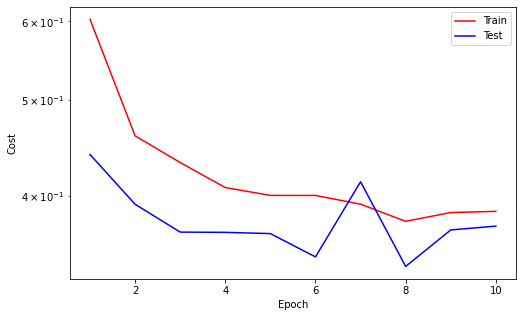

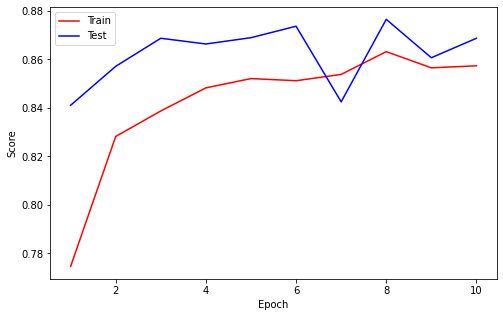

In [16]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

Fase 2: Fine-tuning (learning_rate kecil, patience ditambah)

In [17]:
model.unfreeze()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

callback.reset_early_stop()
callback.early_stop_patience = 5

Test: 100%|██████████| 133/133 [00:37<00:00,  3.58it/s]



Epoch    11
Train_cost  = 0.2862 | Test_cost  = 0.2225 | Train_score = 0.8973 | Test_score = 0.9195 |


Test: 100%|██████████| 133/133 [00:37<00:00,  3.58it/s]



Epoch    12
Train_cost  = 0.2074 | Test_cost  = 0.1864 | Train_score = 0.9255 | Test_score = 0.9360 |


Test: 100%|██████████| 133/133 [00:37<00:00,  3.57it/s]



Epoch    13
Train_cost  = 0.1687 | Test_cost  = 0.1718 | Train_score = 0.9390 | Test_score = 0.9398 |


Test: 100%|██████████| 133/133 [00:37<00:00,  3.57it/s]



Epoch    14
Train_cost  = 0.1513 | Test_cost  = 0.1767 | Train_score = 0.9462 | Test_score = 0.9431 |


Test: 100%|██████████| 133/133 [00:37<00:00,  3.59it/s]



Epoch    15
Train_cost  = 0.1277 | Test_cost  = 0.1563 | Train_score = 0.9557 | Test_score = 0.9443 |


Test: 100%|██████████| 133/133 [00:37<00:00,  3.58it/s]



Epoch    16
Train_cost  = 0.1116 | Test_cost  = 0.1641 | Train_score = 0.9595 | Test_score = 0.9450 |


Test: 100%|██████████| 133/133 [00:37<00:00,  3.58it/s]



Epoch    17
Train_cost  = 0.1010 | Test_cost  = 0.1478 | Train_score = 0.9625 | Test_score = 0.9485 |


Test: 100%|██████████| 133/133 [00:38<00:00,  3.42it/s]



Epoch    18
Train_cost  = 0.0903 | Test_cost  = 0.1529 | Train_score = 0.9679 | Test_score = 0.9481 |
==> EarlyStop patience =  1 | Best test_score: 0.9485


Test: 100%|██████████| 133/133 [00:37<00:00,  3.51it/s]



Epoch    19
Train_cost  = 0.0815 | Test_cost  = 0.1491 | Train_score = 0.9712 | Test_score = 0.9497 |


Test: 100%|██████████| 133/133 [00:37<00:00,  3.52it/s]



Epoch    20
Train_cost  = 0.0711 | Test_cost  = 0.1611 | Train_score = 0.9757 | Test_score = 0.9485 |


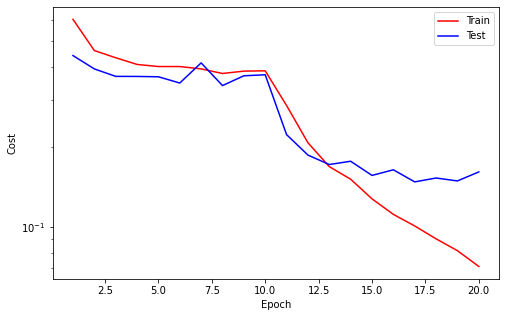

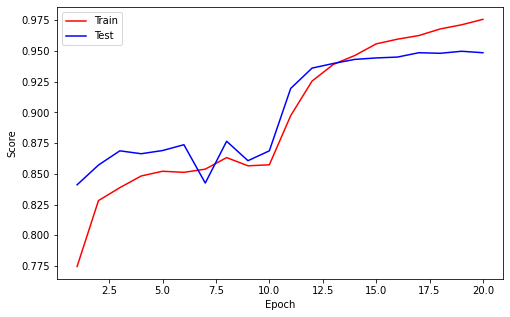

==> EarlyStop patience =  1 | Best test_score: 0.9497


Test: 100%|██████████| 133/133 [00:36<00:00,  3.62it/s]



Epoch    21
Train_cost  = 0.0663 | Test_cost  = 0.1532 | Train_score = 0.9766 | Test_score = 0.9518 |


Test: 100%|██████████| 133/133 [00:37<00:00,  3.54it/s]



Epoch    22
Train_cost  = 0.0560 | Test_cost  = 0.1626 | Train_score = 0.9806 | Test_score = 0.9525 |


Test: 100%|██████████| 133/133 [00:36<00:00,  3.61it/s]



Epoch    23
Train_cost  = 0.0463 | Test_cost  = 0.1556 | Train_score = 0.9843 | Test_score = 0.9504 |
==> EarlyStop patience =  1 | Best test_score: 0.9525


Test: 100%|██████████| 133/133 [00:36<00:00,  3.59it/s]



Epoch    24
Train_cost  = 0.0426 | Test_cost  = 0.1569 | Train_score = 0.9856 | Test_score = 0.9502 |
==> EarlyStop patience =  2 | Best test_score: 0.9525


Test: 100%|██████████| 133/133 [00:36<00:00,  3.61it/s]



Epoch    25
Train_cost  = 0.0443 | Test_cost  = 0.1605 | Train_score = 0.9854 | Test_score = 0.9516 |
==> EarlyStop patience =  3 | Best test_score: 0.9525


Test: 100%|██████████| 133/133 [00:36<00:00,  3.61it/s]



Epoch    26
Train_cost  = 0.0360 | Test_cost  = 0.1736 | Train_score = 0.9884 | Test_score = 0.9476 |
==> EarlyStop patience =  4 | Best test_score: 0.9525


Test: 100%|██████████| 133/133 [00:37<00:00,  3.59it/s]



Epoch    27
Train_cost  = 0.0323 | Test_cost  = 0.1654 | Train_score = 0.9901 | Test_score = 0.9540 |


Test: 100%|██████████| 133/133 [00:36<00:00,  3.62it/s]



Epoch    28
Train_cost  = 0.0296 | Test_cost  = 0.1999 | Train_score = 0.9900 | Test_score = 0.9433 |
==> EarlyStop patience =  1 | Best test_score: 0.9540


Test: 100%|██████████| 133/133 [00:37<00:00,  3.59it/s]



Epoch    29
Train_cost  = 0.0334 | Test_cost  = 0.1954 | Train_score = 0.9894 | Test_score = 0.9476 |
==> EarlyStop patience =  2 | Best test_score: 0.9540


Test: 100%|██████████| 133/133 [00:36<00:00,  3.61it/s]



Epoch    30
Train_cost  = 0.0251 | Test_cost  = 0.1656 | Train_score = 0.9922 | Test_score = 0.9554 |


Test: 100%|██████████| 133/133 [00:37<00:00,  3.59it/s]



Epoch    31
Train_cost  = 0.0200 | Test_cost  = 0.1755 | Train_score = 0.9940 | Test_score = 0.9523 |
==> EarlyStop patience =  1 | Best test_score: 0.9554


Test: 100%|██████████| 133/133 [00:37<00:00,  3.59it/s]



Epoch    32
Train_cost  = 0.0217 | Test_cost  = 0.1908 | Train_score = 0.9931 | Test_score = 0.9506 |
==> EarlyStop patience =  2 | Best test_score: 0.9554


Test: 100%|██████████| 133/133 [00:37<00:00,  3.55it/s]



Epoch    33
Train_cost  = 0.0182 | Test_cost  = 0.1935 | Train_score = 0.9940 | Test_score = 0.9497 |
==> EarlyStop patience =  3 | Best test_score: 0.9554


Test: 100%|██████████| 133/133 [00:37<00:00,  3.56it/s]



Epoch    34
Train_cost  = 0.0178 | Test_cost  = 0.1869 | Train_score = 0.9952 | Test_score = 0.9537 |
==> EarlyStop patience =  4 | Best test_score: 0.9554


Test: 100%|██████████| 133/133 [00:36<00:00,  3.60it/s]



Epoch    35
Train_cost  = 0.0194 | Test_cost  = 0.2086 | Train_score = 0.9941 | Test_score = 0.9518 |
==> EarlyStop patience =  5 | Best test_score: 0.9554
==> Execute Early Stopping at epoch: 35 | Best test_score: 0.9554
==> Best model is saved at model


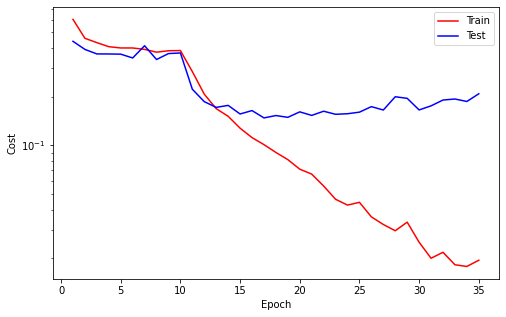

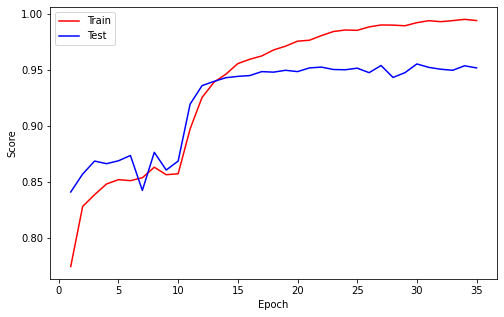

In [18]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

**PREDIKSI**

In [19]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [20]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds

tensor([0, 0, 2, 0, 1, 1, 2, 2, 1, 1, 0, 2, 2, 1, 2, 2, 2, 2, 3, 2, 2, 0, 1, 1,
        0, 1, 1, 2, 2, 2, 1, 1], device='cuda:0')

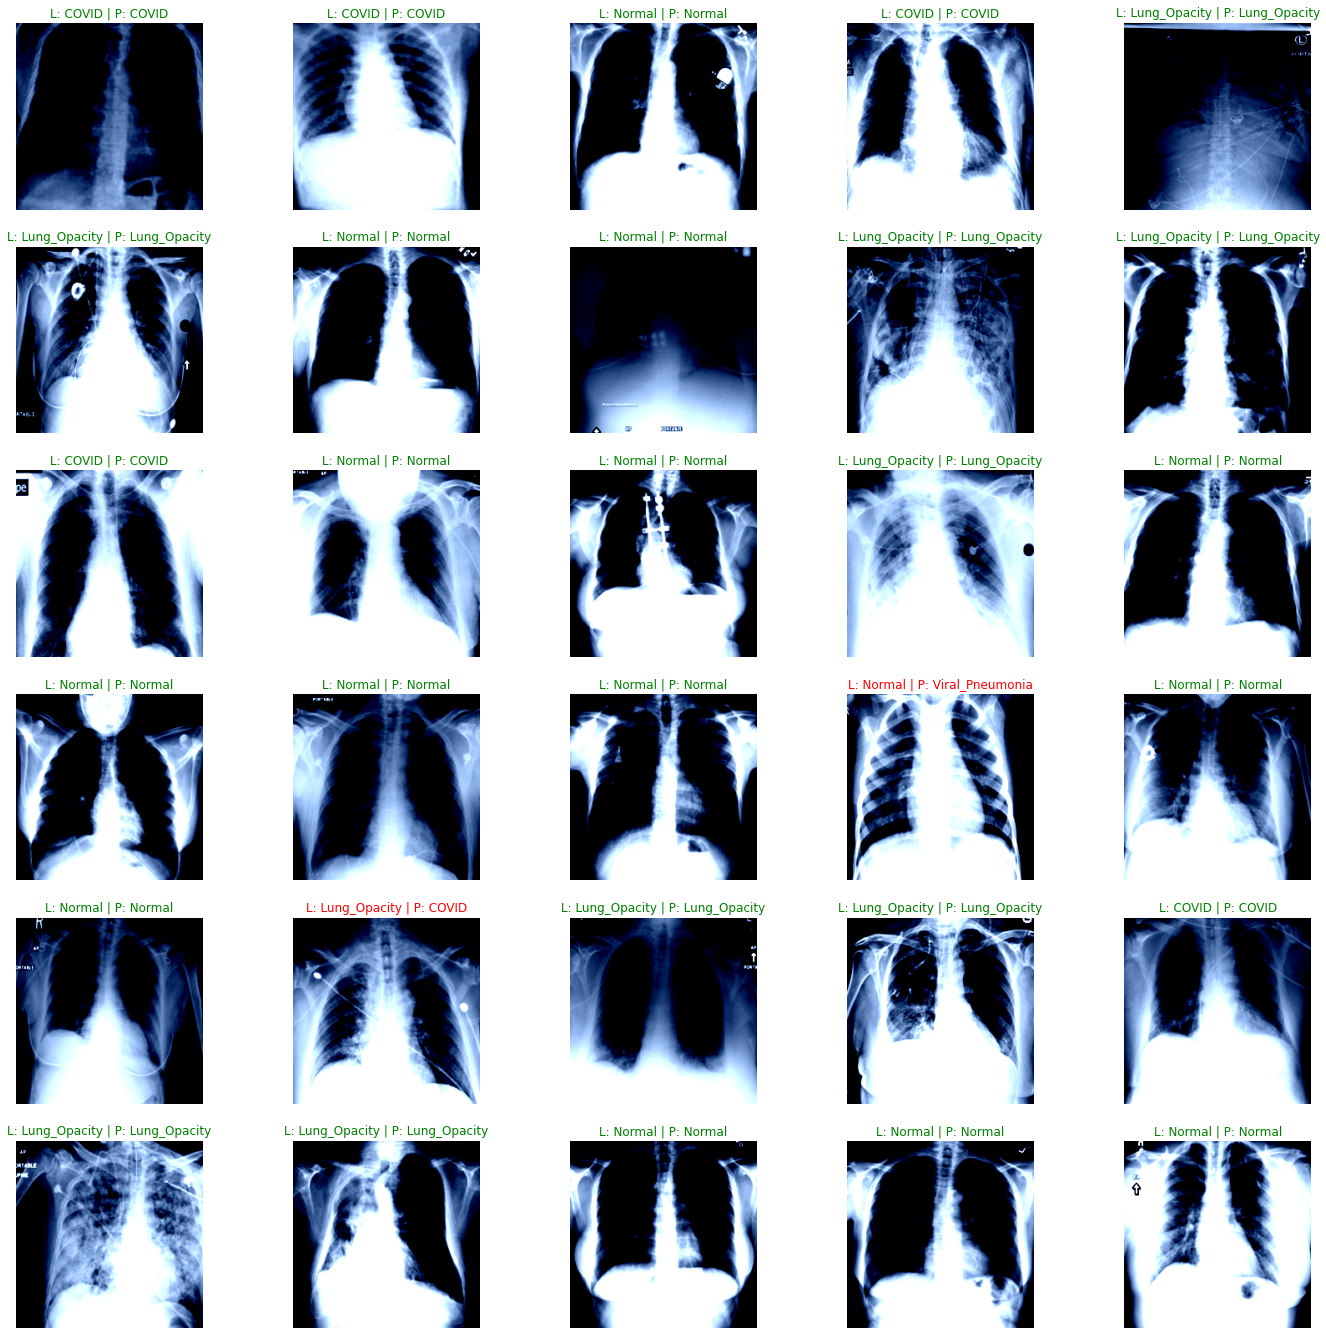

In [21]:
fig, axes = plt.subplots(6, 5, figsize=(24, 24))
for image, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {"color": 'r'} if label != pred else {"color": 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"L: {label} | P: {pred}", fontdict=font);
    ax.axis('off');